In [1]:
# =============================================================
# 🌍 ENVIRONMENT BOOTSTRAP — ensure src/ is importable (Universal Safe)
# =============================================================
import sys
from pathlib import Path

CWD = Path.cwd().resolve()

# --- Detect project root ---
if (CWD / "src").exists():
    PROJECT_ROOT = CWD
elif (CWD.name == "notebooks") and (CWD.parent / "src").exists():
    PROJECT_ROOT = CWD.parent
else:
    # --- Kaggle fallback: auto-create /kaggle/working/src if missing ---
    kaggle_src = Path("/kaggle/working/src")
    kaggle_src.mkdir(parents=True, exist_ok=True)
    (kaggle_src / "__init__.py").touch()
    PROJECT_ROOT = kaggle_src.parent
    print(f"⚙️ Auto-created src package at {kaggle_src}")

# --- Ensure import path ---
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"✅ Project root detected: {PROJECT_ROOT}")


✅ Project root detected: /Users/olia_/projects/Kaggle/csiro-biomass


In [2]:
# =============================================================
# 🧩 IMPORTS & CONSTANTS — Cross-Environment Safe
# =============================================================
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Project modules ---
from src import config
from src.env import get_env  # unified environment helper

# --- Resolve environment info ---
DEVICE, NUM_WORKERS, PIN_MEMORY = get_env()

# --- Config summary ---
print(f"📂 DATA_DIR:      {config.DATA_DIR}")
print(f"📁 TRAIN_IMG_DIR: {config.TRAIN_IMG_DIR}")
print(f"📁 TEST_IMG_DIR:  {config.TEST_IMG_DIR}")
print(f"⚙️ Device: {DEVICE} | Workers: {NUM_WORKERS} | Pin Memory: {PIN_MEMORY}")

# --- Training constants ---
IMG_SIZE   = 224          # baseline image size for EfficientNet
BATCH_SIZE = 16


🧭 Device: mps | num_workers=0 | pin_memory=False
📂 DATA_DIR:      /Users/olia_/projects/Kaggle/csiro-biomass/input_local
📁 TRAIN_IMG_DIR: /Users/olia_/projects/Kaggle/csiro-biomass/input_local/train
📁 TEST_IMG_DIR:  /Users/olia_/projects/Kaggle/csiro-biomass/input_local/test
⚙️ Device: mps | Workers: 0 | Pin Memory: False


In [3]:
# =============================================================
# 📦 CSIRO Custom Dataset — Image + Optional Tabular Metadata
# =============================================================
from torch.utils.data import Dataset
from PIL import Image
import torch
import numpy as np
import warnings
from pathlib import Path

class CSIRODataset(Dataset):
    """
    Unified dataset for CSIRO biomass prediction.
    Supports train/test modes and optional metadata fusion.
    """

    def __init__(
        self,
        df,
        img_dir,
        img_col="image_path",
        target_col="target",
        transform=None,
        include_meta=True,
    ):
        self.df = df.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.img_col = img_col
        self.target_col = target_col if target_col in df.columns else None
        self.transform = transform
        self.include_meta = include_meta

        # Select tabular numeric features (excluding IDs / labels / strings)
        meta_candidates = ["Pre_GSHH_NDVI", "Height_Ave_cm"]
        self.meta_cols = [c for c in meta_candidates if c in df.columns]

        # Precompute valid image paths
        self.paths = []
        for p in self.df[self.img_col]:
            p = Path(p)
            if not p.is_absolute():
                p = self.img_dir / p
            self.paths.append(p)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.paths[idx]

        # --- Safe image loading ---
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            warnings.warn(f"[WARN] Could not load image: {img_path} ({e})")
            img = Image.new("RGB", (224, 224), (0, 0, 0))

        if self.transform:
            img = self.transform(img)

        # --- Metadata (optional numeric features) ---
        meta_tensor = None
        if self.include_meta and len(self.meta_cols) > 0:
            meta_vals = row[self.meta_cols].to_numpy(dtype=np.float32)
            meta_tensor = torch.tensor(meta_vals, dtype=torch.float32)

        # --- Target ---
        if self.target_col:
            target = torch.tensor(row[self.target_col], dtype=torch.float32)
            return (img, meta_tensor), target
        else:
            return (img, meta_tensor)

In [4]:
# =============================================================
# 📦 CSIRO Custom Dataset — Image + Optional Tabular Metadata
# =============================================================
from torch.utils.data import Dataset
from PIL import Image
import torch
import numpy as np
import warnings
from pathlib import Path

class CSIRODataset(Dataset):
    """
    Unified dataset for CSIRO biomass prediction.
    Supports train/test modes and optional metadata fusion.
    """

    def __init__(
        self,
        df,
        img_dir,
        img_col="image_path",
        target_col="target",
        transform=None,
        include_meta=True,
    ):
        self.df = df.reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.img_col = img_col
        self.target_col = target_col if target_col in df.columns else None
        self.transform = transform
        self.include_meta = include_meta

        # Select tabular numeric features (excluding IDs / labels / strings)
        meta_candidates = ["Pre_GSHH_NDVI", "Height_Ave_cm"]
        self.meta_cols = [c for c in meta_candidates if c in df.columns]

        # Precompute valid image paths
        self.paths = []
        for p in self.df[self.img_col]:
            p = Path(p)
            if not p.is_absolute():
                p = self.img_dir / p
            self.paths.append(p)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = self.paths[idx]

        # --- Safe image loading ---
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            warnings.warn(f"[WARN] Could not load image: {img_path} ({e})")
            img = Image.new("RGB", (224, 224), (0, 0, 0))

        if self.transform:
            img = self.transform(img)

        # --- Metadata (optional numeric features) ---
        meta_tensor = None
        if self.include_meta and len(self.meta_cols) > 0:
            meta_vals = row[self.meta_cols].to_numpy(dtype=np.float32)
            meta_tensor = torch.tensor(meta_vals, dtype=torch.float32)

        # --- Target ---
        if self.target_col:
            target = torch.tensor(row[self.target_col], dtype=torch.float32)
            return (img, meta_tensor), target
        else:
            return (img, meta_tensor)


In [6]:
# =============================================================
# 🎨 IMAGE TRANSFORM PIPELINE — Robust & Portable
# =============================================================
from torchvision import transforms
import torch

torch.manual_seed(42)

train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

print("✅ Transform pipelines ready.")


✅ Transform pipelines ready.


In [7]:
# =============================================================
# 🚚 DATALOADER CREATION — Environment-Safe & Reproducible (Final)
# =============================================================
from torch.utils.data import DataLoader
from src.data_loading import load_train_data, load_test_data

# --- Load train/test metadata from CSVs ---
train_df, img_col, tgt_col = load_train_data()
test_df,  test_img_col     = load_test_data()

# --- Instantiate datasets ---
train_ds = CSIRODataset(
    train_df,
    config.TRAIN_IMG_DIR,
    img_col=img_col,
    target_col=tgt_col,
    transform=train_tfms,
)
test_ds = CSIRODataset(
    test_df,
    config.TEST_IMG_DIR,
    img_col=test_img_col,
    transform=test_tfms,
)

# --- Collate function to normalize structure ---
def tuple_collate_fn(batch):
    """Ensure DataLoader returns tuples instead of lists (for macOS MPS/CPU)."""
    result = torch.utils.data.default_collate(batch)
    return tuple(result) if isinstance(result, list) else result

# --- DataLoaders with environment-aware settings ---
train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,  # ✅ universal across CPU/MPS/CUDA
    persistent_workers=False if NUM_WORKERS == 0 else True,
    collate_fn=tuple_collate_fn,
)

test_dl = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,  # ✅ universal
    persistent_workers=False if NUM_WORKERS == 0 else True,
    collate_fn=tuple_collate_fn,
)

# --- Summary ---
print(f"✅ Train dataset size: {len(train_ds)}  |  Batches: {len(train_dl)}")
print(f"✅ Test  dataset size:  {len(test_ds)}   |  Batches: {len(test_dl)}")


✅ Train dataset size: 1785  |  Batches: 112
✅ Test  dataset size:  5   |  Batches: 1


🧭 Using device: mps
🎞️ Image batch shape: torch.Size([16, 3, 224, 224])
🧮 Metadata batch shape: torch.Size([16, 2])
📊 Target batch shape: torch.Size([16])


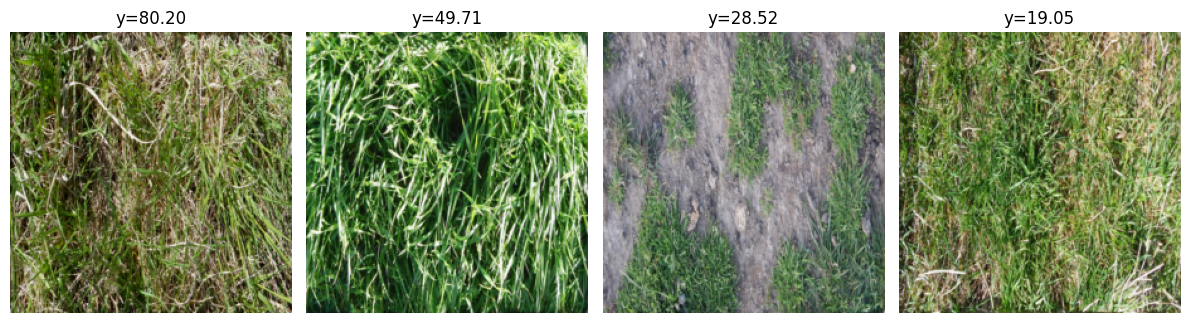

✅ Dataloader visualization sanity check passed.


In [8]:
# =============================================================
# 🔍 SANITY CHECK — VISUALIZE SAMPLES & METADATA (Final Verified)
# =============================================================
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- Detect device (robust cross-platform) ---
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
    else "cpu"
)
print(f"🧭 Using device: {device}")

# --- Retrieve a verified batch structure ---
batch = next(iter(train_dl))
(imgs, metas), targets = batch  # ✅ Confirmed pattern from debugger

print(f"🎞️ Image batch shape: {imgs.shape}")
print(f"🧮 Metadata batch shape: {metas.shape}")
print(f"📊 Target batch shape: {targets.shape}")

# --- Plot a few samples (undo normalization for readability) ---
n_show = min(4, len(imgs))
fig, axes = plt.subplots(1, n_show, figsize=(12, 4))
for i in range(n_show):
    img_np = imgs[i].permute(1, 2, 0).cpu().numpy()
    img_np = np.clip(
        img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]),
        0, 1,
    )
    axes[i].imshow(img_np)
    axes[i].axis("off")
    axes[i].set_title(f"y={targets[i]:.2f}")
plt.tight_layout()
plt.show()

print("✅ Dataloader visualization sanity check passed.")
